In [1]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import json
import collections
import re
from tqdm import tqdm
import itertools

from itertools import islice
from collections import Counter, defaultdict

from itertools import chain
import ast


import statistics
import numpy as np

In [2]:
# Importation données
toEval = pd.read_csv('C:/Users/edgar/OneDrive/Bureau/Ecole/HEC/A24/BrevetNLP/exemple données/test/toEval/2016_G06F_patents_toEval.csv') # /home/edgarlanoue/data/csv/toEval/2016_G06F_patents_toEval.csv 'C:/Users/edgar/OneDrive/Bureau/Ecole/HEC/A24/BrevetNLP/exemple données/toEval/2016_G06F_patents_toEval.csv'
KS = pd.read_csv('C:/Users/edgar/OneDrive/Bureau/Ecole/HEC/A24/BrevetNLP/exemple données/test/KS/2016_1115_G06F_KS_raw.csv') # /home/edgarlanoue/data/csv/KS/2016_1115_G06F_KS_raw.csv C:/Users/edgar/OneDrive/Bureau/Ecole/HEC/A24/BrevetNLP/exemple données/KS/2016_1115_G06F_KS_raw.csv
print("toEval lenght: ", len(toEval))
print("KS lenght: ", len(KS))

toEval lenght:  9234
KS lenght:  173662


In [3]:
# Création différents jdD
toEval_ipc = list([ast.literal_eval(i) for i in toEval.sec_ipc])
KS_ipc = list(set(chain.from_iterable([ast.literal_eval(s) for s in KS.sec_ipc])))

toEval_ipc_clean = [[item for item in sublist if item != item[0]] for sublist in toEval_ipc]


toEval_ipc_short = [list(set(code[:4] for code in sublist)) for sublist in toEval_ipc]
KS_ipc_short = list(set(code[:4] for code in KS_ipc))

toEval_ipc_short_clean = [[item for item in sublist if item != 'G06F'] for sublist in toEval_ipc_short]


print(toEval_ipc)
print(KS_ipc)
print("toEval length ipc: ", len(toEval_ipc))
print("KS length of unique ipc: ", len(KS_ipc))

print(toEval_ipc_clean) 
print("toEval_short_clean length ipc: ", len(toEval_ipc_short_clean)) 

print(toEval_ipc_short) 
print(KS_ipc_short)  
print("toEval_short length ipc: ", len(toEval_ipc_short)) 
print("KS_short length of unique ipc: ", len(KS_ipc_short))    

print(toEval_ipc_short_clean) 
print("toEval_short_clean length ipc: ", len(toEval_ipc_short_clean)) 


[['G06F301', 'G06F3041'], ['G06F312', 'G06Q3004'], ['G06F1730', 'G06F30482', 'G06F30484'], ['G06F9445'], ['G06F3041', 'G06T700', 'G06T520', 'G06F3042', 'G06T500'], ['G06F301', 'G02F113', 'G06T700', 'G02B2700', 'G06F303', 'G02B530', 'G02B2701'], ['G06F2156', 'G06F2157', 'G06F2162'], ['G06F3041', 'G06F3044'], ['G06F1136', 'G06Q1006'], ['G06F128', 'H04W5202', 'H02J702', 'G06F126'], ['G06F1134', 'G06F1130'], ['G06F120897', 'G06F1316'], ['G06F314', 'A63F1326', 'G06F116', 'A63F1324', 'G06F302', 'G06F30338'], ['G06F1730'], ['G06F1730'], ['G06F1114'], ['G06F314', 'G09G33208'], ['G06F1730', 'G06F1727', 'G10L1526'], ['G06F1208'], ['G06F306'], ['G06F301', 'G06F3041', 'G09B502', 'G06F3044'], ['G06F1324', 'G06F306', 'G06F1312', 'G05B19042'], ['G06F1730', 'G06F1727'], ['G06F948', 'H04L12911', 'G06F950'], ['G06F1721', 'H04L2908', 'G06K920'], ['G06F116', 'B60K3500', 'G06F3041', 'G02F11335', 'G02F11333'], ['G06F950', 'H04L2908'], ['G06F306', 'G06F1214'], ['G06F312', 'G07G500'], ['G06F1730'], ['G06F2157

In [4]:
KS_sec_ipc = list(pd.Series([ast.literal_eval(i) for i in KS.sec_ipc]))
KS_sec_ipc_short = [[code[:4] for i, code in enumerate(sublist) if code[:4] not in [code[:4] for code in sublist[:i]]] for sublist in KS_sec_ipc]

## Novelty
- Si apparition d'une classe dans un brevet (incluant classes secondaires) dans toutes les classes (incluant secondaires) du KS
    - IPC
        - Complet
        - Court (4 premières lettres)
    - Score
        - Binaire: apparition d'une nouvelle classe
        - /norme de la longueur des classes secondaires

In [43]:
def novelty_score_norm(toEval_ipc, KS_ipc):
    score = []
    for patent in range(0, len(toEval_ipc)):
        novelty = 0
        for i in range(0, len(toEval_ipc[patent])):
            if toEval_ipc[patent][i] not in KS_ipc:
                novelty += 1
        if len(toEval_ipc[patent])==0:
            score.append(novelty)
        else: score.append(novelty/len(toEval_ipc[patent]))
    return(score)

def novelty_score_bin(toEval_ipc, KS_ipc):
    score = []
    newIPC = [[] for i in range(0, len(toEval_ipc))]
    for patent in range(0, len(toEval_ipc)):
        novelty = 0
        for i in range(0, len(toEval_ipc[patent])):
            if toEval_ipc[patent][i] not in KS_ipc:
                novelty = 1
                newIPC[patent].append(toEval_ipc[patent][i])
        score.append(novelty)
    return(score, newIPC)

In [45]:
# Novelty score

nov_norm = novelty_score_norm(toEval_ipc, KS_ipc)
nov_bin = novelty_score_bin(toEval_ipc, KS_ipc)

# nov_norm_clean = novelty_score_norm(toEval_ipc_clean, KS_ipc)
# nov_bin_clean = novelty_score_bin(toEval_ipc_clean, KS_ipc)


# nov_norm_short = novelty_score_norm(toEval_ipc_short, KS_ipc_short)
# nov_bin_short = novelty_score_bin(toEval_ipc_short, KS_ipc_short)

# nov_norm_short_clean = novelty_score_norm(toEval_ipc_short_clean, KS_ipc_short)
# nov_bin_short_clean = novelty_score_bin(toEval_ipc_short_clean, KS_ipc_short)


In [70]:
# Full IPC
print("Correlation Long IPC: ", np.corrcoef(nov_norm, nov_bin[0])[1,0])

df = pd.DataFrame({
    'Nov Norm Long': [round(i,2) for i in nov_norm],  # Renaming the first column
    'Nov Bin Long': nov_bin[0],   # Renaming the second column
    'New IPCs': nov_bin[1]
})
print("All occurences > 0 are the same: ", all(df[df["Nov Norm Long"]>0]==df[df["Nov Bin Long"]>0]))
print(Counter(df["Nov Bin Long"]))

# Full IPC clean
# print("Correlation Long IPC: ", np.corrcoef(nov_norm_clean, nov_bin_clean[0])[1,0])

# df_clean = pd.DataFrame({
#     'Nov Norm Long clean': [round(i,2) for i in nov_norm_clean],  # Renaming the first column
#     'Nov Bin Long clean': nov_bin_clean[0],   # Renaming the second column
#     'New IPCs': nov_bin_clean[1]
# })
# print("All occurences > 0 are the same: ", all(df_clean[df_clean["Nov Norm Long clean"]>0]==df_clean[df_clean["Nov Bin Long clean"]>0]))
# print(Counter(df_clean["Nov Bin Long clean"]))

# Short IPC 
# print("Correlation Short IPC: ", np.corrcoef(nov_norm_short, nov_bin_short[0])[1,0])

# df_short = pd.DataFrame({
#     'Nov Norm short': [round(i,2) for i in nov_norm_short],  # Renaming the first column
#     'Nov Bin short': nov_bin_short[0],
#     'New IPCs': nov_bin_short[1]
# })
# print("All occurences > 0 are the same: ", all(df_short[df_short["Nov Norm short"]>0]==df_short[df_short["Nov Bin short"]>0]))
# print(Counter(df_short["Nov Bin short"]))

# Short clean IPC 
# print("Correlation Short IPC clean: ", np.corrcoef(nov_norm_short_clean, nov_bin_short_clean[0])[1,0])

# df_short_clean = pd.DataFrame({
#     'Nov Norm short clean': [round(i,2) for i in nov_norm_short_clean],  # Renaming the first column
#     'Nov Bin short clean': nov_bin_short_clean[0],
#     'New IPCs': nov_bin_short_clean[1]
# })
# print("All occurences > 0 are the same: ", all(df_short_clean[df_short_clean["Nov Norm short clean"]>0]==df_short_clean[df_short_clean["Nov Bin short clean"]>0]))
# print(Counter(df_short_clean["Nov Bin short clean"]))

disp = pd.concat([df, pd.DataFrame(pd.Series(toEval_ipc))], axis=1)[df["Nov Norm Long"]>0]
disp.rename(columns={disp.columns[3]: 'toEval'}, inplace=True)
disp[disp["toEval"].apply(lambda x: len(x) == 1)]

Correlation Long IPC:  0.8836258278201922
All occurences > 0 are the same:  True
Counter({0: 8843, 1: 391})


,Nov Norm Long,Nov Bin Long,New IPCs,toEval
529,1.0,1,[G06F12123],[G06F12123]
680,1.0,1,[G06F12121],[G06F12121]
1082,1.0,1,[G06F12123],[G06F12123]
1723,1.0,1,[G06F12122],[G06F12122]
5833,1.0,1,[G06F120811],[G06F120811]
6946,1.0,1,[G06F120891],[G06F120891]
7494,1.0,1,[G06F12121],[G06F12121]
7535,1.0,1,[G06F12122],[G06F12122]


In [72]:
print(Counter(nov_bin[0]))
# print(Counter(nov_bin_clean[0]))
# print(Counter(nov_bin_short[0]))
# print(Counter(nov_bin_short_clean[0]))

# Statistiques
stats_nov = pd.DataFrame({
    '% novelty (long)': round(len([x for x in nov_norm if x>0])/ len(nov_norm)*100, 2), 
    # '% novelty (long clean)': round(len([x for x in nov_norm_clean if x>0])/ len(nov_norm_clean)*100, 2), 
    # '% novelty (short)': round(len([x for x in nov_norm_short if x>0])/ len(nov_norm_short)*100, 3) 
    # '% novelty (short clean)': round(len([x for x in nov_norm_short_clean if x>0])/ len(nov_norm_short_clean)*100, 3)
}, index=[0])
stats_nov

Counter({0: 8843, 1: 391})


,% novelty (long)
0,4.23


Aucune uitlité à enlever la classe principale, à part si on choisit de diviser par la norme.... encore là

## Unique
- Trouver le brevet prototypique dans la KS
    - Par IPC et année... et automatiser ce processus
- Jaccard score de chaque brevet

In [5]:
def jaccard(set1, set2):
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return 1-(len(intersection) / len(union))

set_toEval_ipc = [set(sublist) for sublist in toEval_ipc]

In [9]:
print("Nb IPCs moyens: ", round(np.mean([len(x) for x in KS_sec_ipc if len(x)]),2))
print("Nb IPCs moyens (si en contient > 1): ", round(np.mean([len(x) for x in KS_sec_ipc if len(x)>1]),2))

print("Nb IPCs courts moyens: ", round(np.mean([len(x) for x in KS_sec_ipc_short if len(x)]),2))
print("Nb IPCs courts moyens (si en contient > 1): ", round(np.mean([len(x) for x in KS_sec_ipc_short if len(x)>1]),2))


Nb IPCs moyens:  1.44
Nb IPCs moyens (si en contient > 1):  2.5
Nb IPCs courts moyens:  1.15
Nb IPCs courts moyens (si en contient > 1):  2.16


Énorme problème - pas assez d'IPCs par brevets pour fixer un brevet prototypique...

In [10]:
len_KS_sec = [len(x) for x in KS_sec_ipc if len(x)]

print(Counter(len_KS_sec))
print("Juste 1 IPC: ", round(Counter(len_KS_sec)[1]/len(KS_sec_ipc)*100,1), "%")

Counter({1: 122799, 2: 34367, 3: 10747, 4: 3655, 5: 1335, 6: 479, 7: 161, 8: 66, 9: 27, 10: 10, 11: 9, 14: 2, 21: 1, 15: 1, 12: 1, 20: 1, 13: 1})
Juste 1 IPC:  70.7 %


En prenant simplement les courts, on a encore moins d'IPC par brevet

In [11]:
len_KS_sec_short = [len(x) for x in KS_sec_ipc_short if len(x)]
print(Counter(len_KS_sec_short))
print("Juste 1 IPC: ", round(Counter(len_KS_sec_short)[1]/len(KS_sec_ipc_short)*100,1), "%")

Counter({1: 151824, 2: 18878, 3: 2489, 4: 399, 5: 59, 6: 10, 7: 1, 8: 1, 10: 1})
Juste 1 IPC:  87.4 %


Bref, on doit continuer avec les IPCs complets

In [37]:
df = pd.DataFrame({"KS_sec_ipc": KS_sec_ipc})

# Step 1: Explode the lists into separate rows
exploded_df = df.explode('KS_sec_ipc')

# Step 2: Count occurrences of each unique code
count_series = exploded_df['KS_sec_ipc'].value_counts()

# Step 3: Convert to DataFrame for better readability
count_df = count_series.reset_index()
count_df.columns = ['IPC', 'Count']  # Rename columns

# Display the count DataFrame
print("Nb IPCs")
count_df[:25]

df_g1 = df
df_g1['KS_sec_ipc'] = df['KS_sec_ipc'].apply(lambda x: x if len(x) > 1 else [])
# Step 1: Explode the lists into separate rows
exploded_df_g1 = df_g1.explode('KS_sec_ipc')

# Step 2: Count occurrences of each unique code
count_series_g1 = exploded_df_g1['KS_sec_ipc'].value_counts()

# Step 3: Convert to DataFrame for better readability
count_df_g1 = count_series_g1.reset_index()
count_df_g1.columns = ['IPC (où brevet a > 1 IPC)', 'Count']  # Rename columns

# Display the count DataFrame
count_df_g1

df_g1_clean = df
df_g1_clean['KS_sec_ipc'] = df['KS_sec_ipc'].apply(lambda x: x[1:] if len(x) > 1 else [])
# Step 1: Explode the lists into separate rows
exploded_df_g1_clean = df_g1_clean.explode('KS_sec_ipc')

# Step 2: Count occurrences of each unique code
count_series_g1_clean = exploded_df_g1_clean['KS_sec_ipc'].value_counts()

# Step 3: Convert to DataFrame for better readability
count_df_g1_clean = count_series_g1_clean.reset_index()
count_df_g1_clean.columns = ['IPC (sans classe principale et où brevet a > 1 IPC)', 'Count']  # Rename columns

# Display the count DataFrame
count_df_g1_clean

pd.concat([count_df, count_df_g1, count_df_g1_clean], axis=1)[:25]

Nb IPCs


,IPC,Count,IPC (où brevet a > 1 IPC),Count,IPC (sans classe principale et où brevet a > 1 IPC),Count
0,G06F1730,29339,G06F1730,7637.0,G06F1730,2989.0
1,G06F1516,10289,G06F3041,4881.0,G06F30484,2875.0
2,G06F3041,9025,G06F30484,4674.0,H04L2908,2439.0
3,G06F1900,7210,G06F301,3211.0,G06F3041,2313.0
4,G06F30484,6279,G06F30488,2840.0,G06F30488,2016.0
5,G06F1750,6181,G06F1516,2726.0,G06F1516,1690.0
6,G06F301,5502,G06F1900,2717.0,G06F30481,1588.0
7,G06F944,4963,H04L2908,2439.0,G06F30482,1570.0
8,G06F306,4696,G06F30481,2427.0,H04L2906,1556.0
9,G06F1700,3984,G06F30482,2293.0,G06F3044,1289.0


#### Combinaisons


In [36]:
from itertools import combinations
def count_combinations(series, combo_size):
    # List to hold combinations
    all_combinations = []
    
    # Iterate over each row in the series
    for sublist in series:
        # Generate combinations of the specified size
        if len(sublist) >= combo_size:  # Only consider lists with enough elements
            all_combinations.extend(combinations(sorted(sublist), combo_size))
    
    # Count occurrences of each combination
    combination_counts = Counter(all_combinations)
    
    return combination_counts

In [27]:
pair_counts1 = count_combinations([sublist for sublist in KS_sec_ipc], 1)
pair_counts_df1 = pd.DataFrame(pair_counts1.items(), columns=['Combination1', 'Count1']).sort_values(by='Count1', ascending=False)
pair_counts2 = count_combinations([sublist for sublist in KS_sec_ipc], 2)
pair_counts_df2 = pd.DataFrame(pair_counts2.items(), columns=['Combination2', 'Count2']).sort_values(by='Count2', ascending=False)
pair_counts3 = count_combinations([sublist for sublist in KS_sec_ipc], 3)
pair_counts_df3 = pd.DataFrame(pair_counts3.items(), columns=['Combination3', 'Count3']).sort_values(by='Count3', ascending=False)

pair_counts1fr = count_combinations([sublist for sublist in KS_sec_ipc if len(sublist)==1], 1)
pair_counts_df1fr = pd.DataFrame(pair_counts1fr.items(), columns=['Combination1', 'Count1']).sort_values(by='Count1', ascending=False)
pair_counts2fr = count_combinations([sublist for sublist in KS_sec_ipc if len(sublist)==2], 2)
pair_counts_df2fr = pd.DataFrame(pair_counts2fr.items(), columns=['Combination2', 'Count2']).sort_values(by='Count2', ascending=False)
pair_counts3fr = count_combinations([sublist for sublist in KS_sec_ipc if len(sublist)==3], 3)
pair_counts_df3fr = pd.DataFrame(pair_counts3fr.items(), columns=['Combination3', 'Count3']).sort_values(by='Count3', ascending=False)
pair_counts4fr = count_combinations([sublist for sublist in KS_sec_ipc if len(sublist)==4], 4)
pair_counts_df4fr = pd.DataFrame(pair_counts4fr.items(), columns=['Combination4', 'Count4']).sort_values(by='Count4', ascending=False)

print(pair_counts_df1[:10])
print(pair_counts_df2[:10])
print(pair_counts_df3[:10])

print(pair_counts_df1fr[:20])
print(pair_counts_df2fr[:10])
print(pair_counts_df3fr[:10])
print(pair_counts_df4fr[:10])


     Combination1  Count1
14    (G06F1730,)   29339
12    (G06F1516,)   10289
33    (G06F3041,)    9025
28    (G06F1900,)    7210
733  (G06F30484,)    6279
3     (G06F1750,)    6181
10     (G06F301,)    5502
0      (G06F944,)    4963
948    (G06F306,)    4696
19    (G06F1700,)    3984
                Combination2  Count2
2335  (G06F30482, G06F30484)    1494
3681  (G06F30481, G06F30484)    1435
22      (G06F3041, G06F3044)    1425
5139  (G06F30484, G06F30488)    1371
1742    (G06F1730, H04L2908)    1044
2809   (G06F3041, G06F30488)     810
2810  (G06F30481, G06F30488)     725
2346   (G06F1730, G06F30484)     697
65       (G06F301, G06F3041)     675
5000  (G06F30481, G06F30482)     649
                           Combination3  Count3
4110  (G06F30481, G06F30484, G06F30488)     437
4111  (G06F30482, G06F30484, G06F30488)     408
3377  (G06F30481, G06F30482, G06F30484)     370
1138   (G06F1730, G06F30482, G06F30484)     273
7561   (G06F3041, G06F30484, G06F30488)     271
4109  (G06F30481, G

In [138]:
data1 = pd.DataFrame({
    'Combination1': [('G06F1730',), ('G06F1516',), ('G06F3041',)],
    'Count1': [29339, 10289, 9025]
})
data2 = pd.DataFrame({
    'Combination2': [('G06F30482', 'G06F30484'), ('G06F30481', 'G06F30484')],
    'Count2': [1494, 1435]
})
data3 = pd.DataFrame({
    'Combination3': [('G06F30481', 'G06F30484', 'G06F30488'), ('G06F30482', 'G06F30484', 'G06F30488')],
    'Count3': [437, 408]
})

# Flatten combinations and calculate frequencies
from collections import Counter

def flatten_combinations(data, column):
    return Counter([ipc for combination in data[column] for ipc in combination])

freq1 = flatten_combinations(pair_counts1, 'Combination1')
freq2 = flatten_combinations(data2, 'Combination2')
freq3 = flatten_combinations(data3, 'Combination3')

print(freq1)
print(freq2)
print(freq3)
# Merge frequencies to get a combined score
ipc_freq = Counter(freq1) + Counter(freq2) + Counter(freq3)

# Display IPCs with highest frequencies as prototypical
prototypical_ipcs = ipc_freq.most_common(5)
print("Prototypical IPCs:", prototypical_ipcs)

Counter({'G06F1730': 1, 'G06F1516': 1, 'G06F3041': 1})
Counter({'G06F30484': 2, 'G06F30482': 1, 'G06F30481': 1})
Counter({'G06F30484': 2, 'G06F30488': 2, 'G06F30481': 1, 'G06F30482': 1})
Prototypical IPCs: [('G06F30484', 4), ('G06F30482', 2), ('G06F30481', 2), ('G06F30488', 2), ('G06F1730', 1)]


In [34]:
def is_combination_in_list(combination, combinations_list):
    """
    Check if the given combination exists in the list of combinations.
    
    Parameters:
    - combination: List of elements to check.
    - combinations_list: List of combinations (each combination is also a list).
    
    Returns:
    - True if the combination is found, False otherwise.
    """
    # Convert the combination to a set for unordered comparison
    combination_set = set(combination)

    # Check if any combination in the list matches the combination set
    for comb in combinations_list:
        if combination_set == set(comb):
            return True
            
    return False

def generate_ordered_combinations(real_list, n):
    # Length of the input list
    length = len(real_list)
    lst = list(range(length))
    combo_vec =[]
    # Create combinations by iterating through the list
    for start in range(length - n + 1):  # Adjust the range to prevent overflow
        for offset in range(length - n + 1):
            # Create combinations using a loop
            for i in range(0, n):
                if start + n + offset < length:
                    # Create a combination where the last 'i' elements are adjusted
                    combo = lst[start:start + n - i] + lst[start + n - i + offset + 1:start + n + offset + 1]
                    # Remove duplicates by converting to a set and back to a list
                    combo_vec.append(combo)
                    
                    # Sort to maintain consistency in order (optional)
                    # combo.sort()
    seen = set()
    unique_list = []
    for sublist in combo_vec:
        # Convert the sublist to a tuple
        sublist_tuple = tuple(sublist)
        # If the tuple is not in 'seen', add it to 'seen' and 'unique_list'
        if sublist_tuple not in seen:
            seen.add(sublist_tuple)
            unique_list.append(sublist)
    unique_list=sorted(unique_list, key=sum)
    mapped_ipc_codes = [[real_list[idx] for idx in rank] for rank in unique_list]
    return mapped_ipc_codes

In [38]:
n1=6
top_ipc_codes = list(count_df.iloc[:n1, 0])
top_ipc_codes_g1 = list(count_df_g1.iloc[:n1, 0])
top_ipc_codes_g1_clean = list(count_df_g1_clean.iloc[:n1, 0])

print(top_ipc_codes)
print(top_ipc_codes_g1)
print(top_ipc_codes_g1_clean)

['G06F1730', 'G06F1516', 'G06F3041', 'G06F1900', 'G06F30484', 'G06F1750']
['G06F1730', 'G06F3041', 'G06F30484', 'G06F301', 'G06F30488', 'G06F1516']
['G06F1730', 'G06F30484', 'H04L2908', 'G06F3041', 'G06F30488', 'G06F1516']


In [39]:
n2 =3

print(f"Exemple de combinaisons avec {list(range(n1))}")
for combi in generate_ordered_combinations(list(range(n1)), n2):
    print(f"Combi: {combi} ")
print("")

print("Plus fréquents")
for combi in generate_ordered_combinations(top_ipc_codes, n2):
    print(f"Combi: {combi} ", is_combination_in_list(combi, KS_sec_ipc))
print("")
print("Plus fréquents où > 1 IPC")
for combi in generate_ordered_combinations(top_ipc_codes_g1, n2):
    print(f"Combi: {combi} ", is_combination_in_list(combi, KS_sec_ipc))
print("")
print("Plus fréquents où > 1 IPC et sans classe principale")
for combi in generate_ordered_combinations(top_ipc_codes_g1_clean, n2):
    print(f"Combi: {combi} ", is_combination_in_list(combi, KS_sec_ipc))
print("")


Exemple de combinaisons avec [0, 1, 2, 3, 4, 5]
Combi: [0, 1, 2] 
Combi: [0, 1, 3] 
Combi: [0, 2, 3] 
Combi: [0, 1, 4] 
Combi: [0, 1, 5] 
Combi: [1, 2, 3] 
Combi: [0, 3, 4] 
Combi: [1, 2, 4] 
Combi: [1, 3, 4] 
Combi: [1, 2, 5] 
Combi: [0, 4, 5] 
Combi: [2, 3, 4] 
Combi: [1, 4, 5] 
Combi: [2, 3, 5] 
Combi: [2, 4, 5] 

Plus fréquents
Combi: ['G06F1730', 'G06F1516', 'G06F3041']  False
Combi: ['G06F1730', 'G06F1516', 'G06F1900']  False
Combi: ['G06F1730', 'G06F3041', 'G06F1900']  False
Combi: ['G06F1730', 'G06F1516', 'G06F30484']  False
Combi: ['G06F1730', 'G06F1516', 'G06F1750']  False
Combi: ['G06F1516', 'G06F3041', 'G06F1900']  False
Combi: ['G06F1730', 'G06F1900', 'G06F30484']  True
Combi: ['G06F1516', 'G06F3041', 'G06F30484']  False
Combi: ['G06F1516', 'G06F1900', 'G06F30484']  False
Combi: ['G06F1516', 'G06F3041', 'G06F1750']  False
Combi: ['G06F1730', 'G06F30484', 'G06F1750']  False
Combi: ['G06F3041', 'G06F1900', 'G06F30484']  False
Combi: ['G06F1516', 'G06F30484', 'G06F1750']  Fal

très difficile de setter un brevet prototypique

Solution non optimale: Prendre le brevet le plus courant seulement

In [40]:
# Find unique IPC codes
all_ipc_codes = set(ipc for patent in KS_sec_ipc for ipc in patent)
ipc_list = sorted(all_ipc_codes)  # Sort for consistent order


In [ ]:
# # Initialize DataFrame with zeros
# data = pd.DataFrame(0, index=range(len(KS_sec_ipc)), columns=ipc_list)

# # Fill in the DataFrame
# for i, patent in enumerate(KS_sec_ipc):
#     for ipc in patent:
#         data.at[i, ipc] = 1

# print("Binary matrix of IPC codes:\n", data)

In [145]:
# from scipy.spatial.distance import pdist, squareform

# # Calculate Jaccard distance between columns (IPC codes)
# distance_matrix = pdist(data.T, metric='jaccard')
# distance_matrix_square = squareform(distance_matrix)  # Convert to a square form for readability

# print("Distance matrix:\n", pd.DataFrame(distance_matrix_square, 
#                                          index=data.columns, columns=data.columns))

Distance matrix:
          A01G100  A23F318  A23F526  A41B108  A41D100  A41D1900  A41D300  \
A01G100      0.0      1.0      1.0      1.0      1.0       1.0      1.0   
A23F318      1.0      0.0      0.0      1.0      1.0       1.0      1.0   
A23F526      1.0      0.0      0.0      1.0      1.0       1.0      1.0   
A41B108      1.0      1.0      1.0      0.0      0.5       1.0      1.0   
A41D100      1.0      1.0      1.0      0.5      0.0       1.0      0.5   
...          ...      ...      ...      ...      ...       ...      ...   
H05K714      1.0      1.0      1.0      1.0      1.0       1.0      1.0   
H05K716      1.0      1.0      1.0      1.0      1.0       1.0      1.0   
H05K718      1.0      1.0      1.0      1.0      1.0       1.0      1.0   
H05K720      1.0      1.0      1.0      1.0      1.0       1.0      1.0   
H05K900      1.0      1.0      1.0      1.0      1.0       1.0      1.0   

         A42B304  A42B330  A44C1500  ...  H05K346  H05K500  H05K502  H05K503  \
A

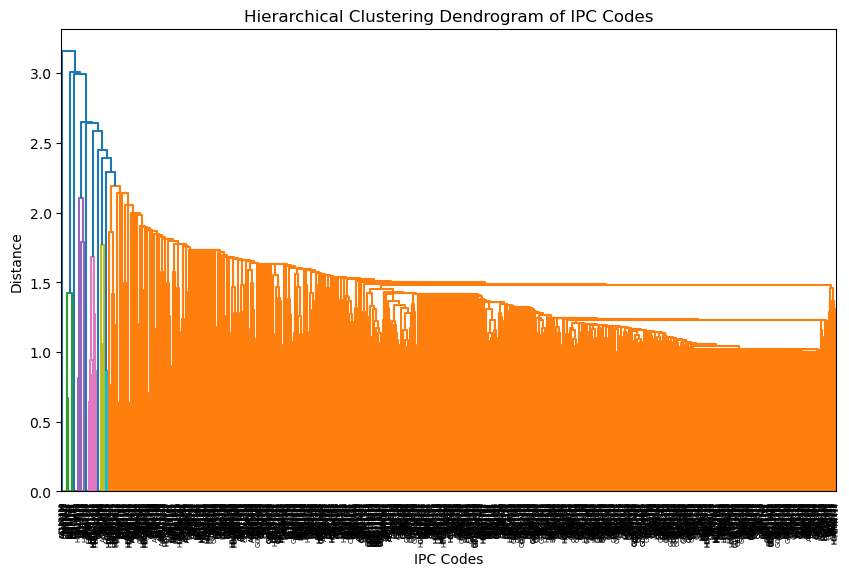

In [146]:
# from scipy.cluster.hierarchy import linkage, dendrogram
# import matplotlib.pyplot as plt

# # Perform hierarchical clustering
# linkage_matrix = linkage(distance_matrix, method='ward')

# # Plot the dendrogram to visualize the clustering
# plt.figure(figsize=(10, 6))
# dendrogram(linkage_matrix, labels=data.columns, leaf_rotation=90)
# plt.title("Hierarchical Clustering Dendrogram of IPC Codes")
# plt.xlabel("IPC Codes")
# plt.ylabel("Distance")
# plt.show()

In [149]:
# from scipy.cluster.hierarchy import fcluster

# # Set a threshold to extract clusters (e.g., height = 0.5)
# threshold = 0.5
# clusters = fcluster(linkage_matrix, threshold, criterion='distance')

# # Display IPC codes with their assigned cluster
# cluster_df = pd.DataFrame({'IPC': data.columns, 'Cluster': clusters})
# print("IPC Codes with their assigned clusters:\n", cluster_df.sort_values('Cluster'))

IPC Codes with their assigned clusters:
             IPC  Cluster
107    A61Q1300        1
256     C11B900        1
257    C11D1100        1
258     C11D350        1
80      A61K833        1
...         ...      ...
1508    H04W416     1240
817    G06Q2032     1241
1350  H04M12745     1242
1507    H04W414     1243
1505    H04W408     1244

[1566 rows x 2 columns]


In [150]:
# # Count the frequency of each IPC code
# ipc_counts = data.sum().sort_values(ascending=False)
# print("IPC Counts:\n", ipc_counts)


IPC Counts:
 G06F1730    1583
G06F306     1227
G06F3041     860
G06F3044     536
G06F944      461
            ... 
G04C300        1
G04G1706       1
G04G1900       1
G04G2100       1
G06K924        1
Length: 1566, dtype: int64


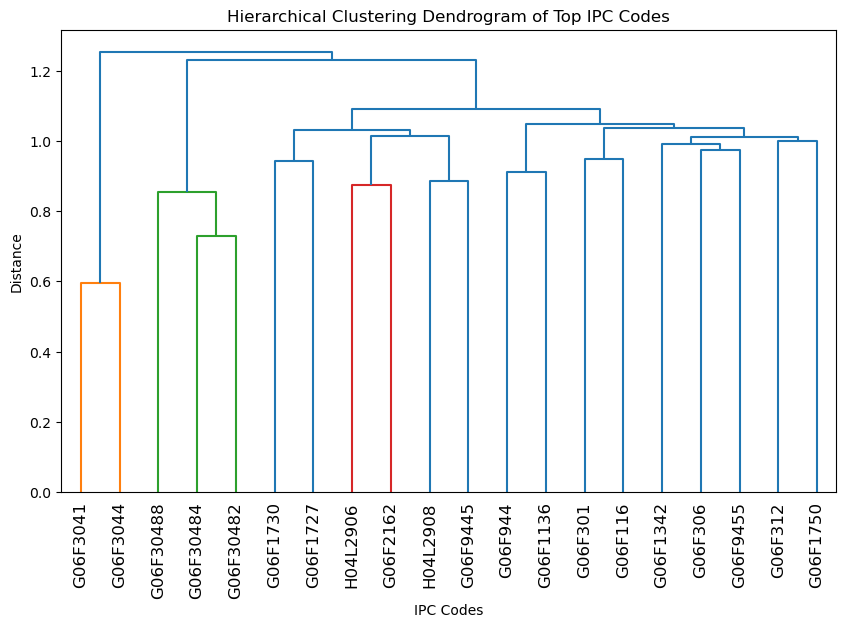

In [153]:
# top_n = 20  # Specify how many IPC codes you want to keep
# top_ipcs = ipc_counts.head(top_n).index.tolist()
# data_subset = data[top_ipcs]

# # Calculate Jaccard distance for the subset of IPCs
# distance_matrix_subset = pdist(data_subset.T, metric='jaccard')
# linkage_matrix_subset = linkage(distance_matrix_subset, method='ward')

# # Plot the dendrogram for the subset
# plt.figure(figsize=(10, 6))
# dendrogram(linkage_matrix_subset, labels=top_ipcs, leaf_rotation=90)
# plt.title("Hierarchical Clustering Dendrogram of Top IPC Codes")
# plt.xlabel("IPC Codes")
# plt.ylabel("Distance")
# plt.show()


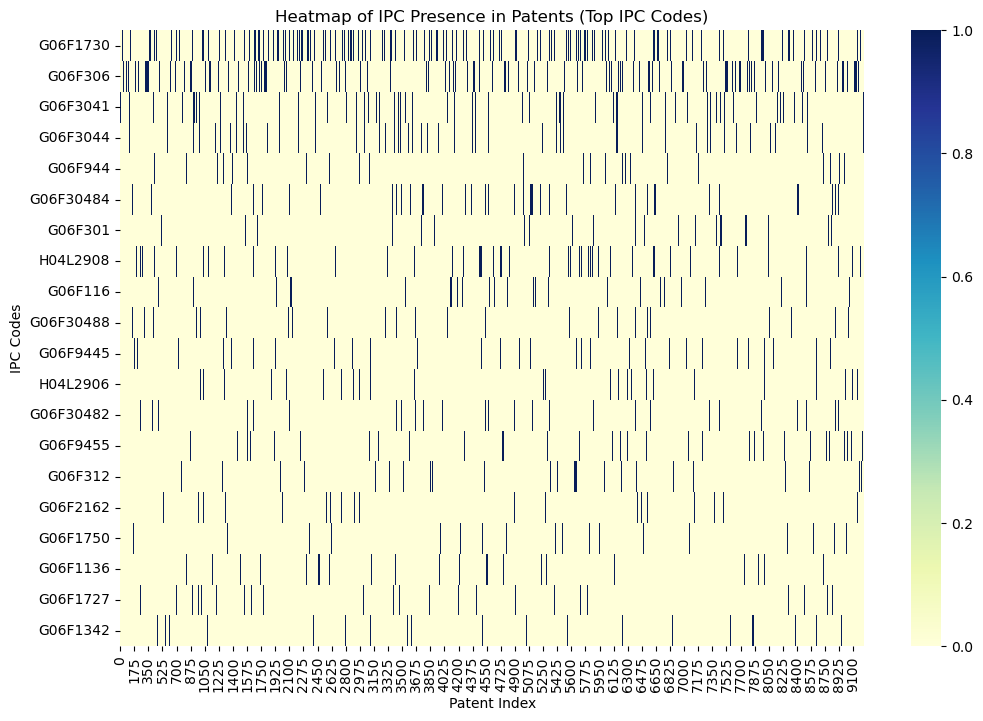

In [154]:
# import seaborn as sns

# # Create a heatmap of the subset
# plt.figure(figsize=(12, 8))
# sns.heatmap(data_subset.T, cmap='YlGnBu', cbar=True, annot=False)
# plt.title("Heatmap of IPC Presence in Patents (Top IPC Codes)")
# plt.xlabel("Patent Index")
# plt.ylabel("IPC Codes")
# plt.show()


In [43]:
proto = {top_ipc_codes[0]}
print(proto)
print(set_toEval_ipc[13])
1-jaccard(set_toEval_ipc[13], proto)



{'G06F1730'}
{'G06F1730'}


0.0

In [44]:
def unique_score(toEval_ipc, proto):
    score = []
    for patent in range(0, len(toEval_ipc)):
        jaccard_dist = 1-jaccard(toEval_ipc[patent], proto)
        score.append(jaccard_dist)
    return(score)

In [45]:
unique = unique_score(set_toEval_ipc, proto)

In [46]:
Counter(unique)

Counter({1.0: 7651,
         0.6666666666666667: 275,
         0.0: 595,
         0.5: 455,
         0.75: 139,
         0.8333333333333334: 23,
         0.8: 65,
         0.875: 6,
         0.9230769230769231: 1,
         0.8571428571428572: 16,
         0.9166666666666666: 1,
         0.8888888888888888: 7})

In [47]:
Counter([ipc for sublist in toEval_ipc for ipc in sublist if len(sublist) == 1]).most_common

<bound method Counter.most_common of Counter({'G06F1730': 594, 'G06F306': 459, 'G06F1750': 180, 'G06F1136': 132, 'G06F116': 114, 'G06F944': 114, 'G06F312': 105, 'G06F3041': 90, 'G06F1107': 73, 'G06F3044': 65, 'G06F9445': 63, 'G06F9455': 54, 'G06F945': 53, 'G06F950': 52, 'G06F132': 51, 'G06F930': 48, 'G06F1208': 41, 'G06F1114': 31, 'G06F1727': 31, 'G06F301': 30, 'G06F1900': 28, 'G06F2162': 23, 'G06F118': 23, 'G06F954': 22, 'G06F3042': 20, 'G06F1202': 19, 'G06F938': 16, 'G06F30354': 15, 'G06F1120': 13, 'G06F1210': 12, 'G06F2156': 12, 'G06F948': 11, 'G06F316': 10, 'G06F30488': 9, 'G06F126': 7, 'G06F120': 7, 'G06F2157': 7, 'G06F1724': 7, 'G06F30481': 6, 'G06F302': 6, 'G06F1340': 6, 'G06F1214': 6, 'G06F1206': 6, 'G06F1324': 6, 'G06F1721': 6, 'G06F946': 5, 'G06F30484': 5, 'G06F2160': 5, 'G06F2131': 5, 'G06F2132': 5, 'G06F128': 5, 'G06F758': 5, 'G06F3047': 5, 'G06F1728': 5, 'G06F2110': 4, 'G06F2155': 4, 'G06F952': 4, 'G06F1716': 4, 'G06F1110': 4, 'G06F3023': 3, 'G06F1714': 3, 'G06F1722': 3, '

In [33]:
len(toEval_ipc) 

9234

In [32]:
proto = list(Counter([tuple(sublist) for sublist in KS_sec_ipc]).most_common(1)[0][0])
proto

['G06F1730']

In [33]:
def unique_score(toEval_ipc, proto):
    score = []
    for patent in range(0, len(toEval_ipc)):
        jaccard_dist = jaccard(toEval_ipc[patent], proto)
        score.append(jaccard_dist)
    return(score)

In [41]:
unique = unique_score(set_toEval_ipc, proto)
Counter(unique)

Counter({1.0: 7651,
         0.0: 595,
         0.5: 455,
         0.6666666666666667: 275,
         0.75: 139,
         0.8: 65,
         0.8333333333333334: 23,
         0.8571428571428572: 16,
         0.8888888888888888: 7,
         0.875: 6,
         0.9230769230769231: 1,
         0.9166666666666666: 1})

## Différent

In [5]:
def jaccard(set1, set2):
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return (len(intersection) / len(union))

In [ ]:
# Test Jaccard
set_toEval_ipc = [set(sublist) for sublist in toEval_ipc]
protoPatent = set(['G06F30484', 'G06F1730', 'G06F3041'])

print(set_toEval_ipc[:10])
print(protoPatent)
jaccard(set(protoPatent), set_toEval_ipc[2])

[{'G06F3041', 'G06F301'}, {'G06F312', 'G06Q3004'}, {'G06F30482', 'G06F1730', 'G06F30484'}, {'G06F9445'}, {'G06F3041', 'G06T700', 'G06T500', 'G06T520', 'G06F3042'}, {'G02B2701', 'G06T700', 'G02B530', 'G06F303', 'G02B2700', 'G02F113', 'G06F301'}, {'G06F2162', 'G06F2156', 'G06F2157'}, {'G06F3041', 'G06F3044'}, {'G06F1136', 'G06Q1006'}, {'G06F126', 'H02J702', 'G06F128', 'H04W5202'}]
{'G06F3041', 'G06F1730', 'G06F30484'}


0.5

In [ ]:
# Création matrice de 3000*3000 avec 3000 brevets du KS
ipc_rand = (pd.Series(KS_sec_ipc).sample(n=3000, random_state=41))
ipc_rand2 = (pd.Series(KS_sec_ipc).sample(n=3000, random_state=43))
ipc_rand = [set(sublist) for sublist in ipc_rand]
ipc_rand2 = [set(sublist) for sublist in ipc_rand2]
print(ipc_rand[:10])

# Initialisation de la matrice
size = len(ipc_rand)
jaccard_matrix = np.zeros((size, size))

# Remplir la matrice à l'aide de la distance de Jaccard (1-mesure de Jaccard)
for i in range(size):
    for j in range(size):
        jaccard_matrix[i][j] = 1-jaccard(ipc_rand[i], ipc_rand2[j])

    
# Convert the matrix to a DataFrame for better visualization
jaccard_dist = round(pd.DataFrame(jaccard_matrix, columns=[f'Brevet {i+1}' for i in range(size)], index=[f'Brevet {i+1}' for i in range(size)]),2)
jaccard_dist

[{'G06F1516'}, {'G06F944'}, {'G06F1750'}, {'G06F1340'}, {'G06F126'}, {'G06F1750'}, {'G06F1324'}, {'G01C2136', 'G06F700'}, {'G06F3041', 'G06F116', 'G06F3044'}, {'G06F306', 'G06F1730'}]


,Brevet 1,Brevet 2,Brevet 3,Brevet 4,Brevet 5,Brevet 6,Brevet 7,Brevet 8,Brevet 9,Brevet 10,...,Brevet 2991,Brevet 2992,Brevet 2993,Brevet 2994,Brevet 2995,Brevet 2996,Brevet 2997,Brevet 2998,Brevet 2999,Brevet 3000
Brevet 1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Brevet 2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Brevet 3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Brevet 4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Brevet 5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Brevet 2996,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Brevet 2997,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Brevet 2998,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Brevet 2999,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [32]:
def mean_closest(jaccard_dist_matrix, n):
    mean_closest = []
    size = len(jaccard_dist_matrix)
    for i in range(size):
        # Get the row and exclude the diagonal (self-comparison)
        row = jaccard_matrix[i]
        closest_indices = np.argsort(row)[:n]   # Garder les n plus proche voisin sauf soi
        mean_value = np.mean(row[closest_indices]) # faire la moyenne des distances ces n pts
        mean_closest.append(mean_value)
    seuil = statistics.mean(mean_closest)
    return(seuil)


In [33]:
seuil10 = mean_closest(jaccard_matrix, 10)
seuil100 = mean_closest(jaccard_matrix, 100)

print("Seuil avec 10: ", seuil10)
print("Seuil avec 100: ", seuil100)

Seuil avec 10:  0.19455636002886004
Seuil avec 100:  0.5178213236042281


In [15]:
# Score de différence sur toEval (slmnt 500 premiers brevets)

def dif_vec(toEval_ipc_set, seuil):
    n=500
    dif_bin = [[] for i in toEval_ipc_set[:n]]
    for idx, i in enumerate(tqdm(toEval_ipc_set[:n])):
        for j in KS_sec_ipc:
            if jaccard(i, j) >= seuil:
                dif_bin[idx].append(1)
            else:
                dif_bin[idx].append(0)
    return(dif_bin)

In [22]:
dif_vec_10 = dif_vec(set_toEval_ipc, seuil10)
dif_vec_100 = dif_vec(set_toEval_ipc, seuil100)

100%|██████████| 500/500 [01:09<00:00,  7.24it/s]


In [23]:
def dif_score_ratio(toEval_ipc, dif_bin):
    n=500
    dif_ratio_vec = []
    for i in range(len(toEval_ipc[:n])):
        dif_ratio_vec.append(len([value for value in dif_bin[i] if value == 1])/len(dif_bin[i]))
    dif_ratio = np.mean(dif_ratio_vec)
    return(dif_ratio, dif_ratio_vec)

In [35]:
dif_ratio_10 = dif_score_ratio(toEval_ipc, dif_vec_10)
dif_ratio_100 = dif_score_ratio(toEval_ipc, dif_vec_100)

print("Moyenne des ratios (seuil10): ", round(dif_ratio_10[0],3))
print("Moyenne des ratios (seuil100): ", round(dif_ratio_100[0],3))

Moyenne des ratios (seuil10):  0.053
Moyenne des ratios (seuil100):  0.013


In [25]:
dif_mat_10 = np.array(dif_vec_10)
print(dif_mat_10.shape)
print(dif_mat_10)
dif_mat_100 = np.array(dif_vec_100)
print(dif_mat_100.shape)
print(dif_mat_100)

(500, 173662)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]
(500, 173662)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]]


In [26]:
column_sums = np.sum(dif_mat_10, axis=0)
print("Column sums:", column_sums) 
print("Column sums length:", len(column_sums))  

# Count occurrences
occurrences = Counter(column_sums)
print(occurrences)
# Extract keys and values
labels = occurrences.keys()
counts = occurrences.values()

column_sums100 = np.sum(dif_mat_100, axis=0)
print("Column sums:", column_sums100) 
print("Column sums length:", len(column_sums100))  

# Count occurrences
occurrences100 = Counter(column_sums100)
print(occurrences100)
# Extract keys and values
labels100 = occurrences100.keys()
counts100 = occurrences100.values()

Column sums: [19  0 12 ... 11 12 91]
Column sums length: 173662
Counter({0: 35102, 91: 21852, 8: 10414, 12: 8995, 19: 6391, 1: 5797, 3: 5185, 7: 5176, 15: 4946, 11: 4925, 9: 4832, 56: 4210, 10: 4162, 4: 4050, 5: 4038, 2: 3534, 75: 2939, 6: 2880, 14: 2610, 13: 2449, 25: 2021, 89: 1983, 35: 1744, 18: 1489, 23: 1351, 21: 1162, 58: 1144, 30: 999, 27: 860, 48: 762, 17: 668, 100: 623, 22: 581, 90: 580, 20: 567, 29: 567, 24: 558, 16: 542, 31: 517, 92: 504, 32: 447, 26: 433, 95: 426, 50: 390, 104: 387, 105: 346, 49: 312, 76: 309, 80: 308, 59: 278, 55: 266, 28: 251, 78: 248, 85: 242, 97: 242, 98: 238, 36: 228, 39: 210, 93: 207, 38: 192, 94: 192, 74: 182, 41: 176, 33: 167, 53: 163, 86: 133, 96: 126, 99: 124, 65: 122, 64: 118, 40: 114, 88: 110, 37: 100, 34: 96, 47: 95, 87: 87, 42: 87, 52: 85, 51: 83, 160: 80, 82: 80, 101: 70, 43: 69, 57: 67, 67: 67, 66: 63, 72: 61, 71: 60, 54: 59, 103: 58, 70: 57, 83: 57, 107: 54, 44: 54, 62: 54, 108: 53, 46: 50, 79: 50, 102: 49, 77: 49, 81: 48, 69: 47, 45: 44, 6

In [27]:
diff_occu=pd.Series(KS_sec_ipc)[column_sums==91]
print(diff_occu.value_counts()[:5])

diff_occu100=pd.Series(KS_sec_ipc)[column_sums100==40]
print(diff_occu100.value_counts()[:5])

[G06F1730]              21702
[G06F1730, G06F1728]       29
[G06F1730, H04L1224]       17
[G06F1730, H04W402]        14
[G06F1728, G06F1730]       12
dtype: int64
[G06F1730]    21702
dtype: int64


### Nouvelle différence


In [16]:
type(KS_sec_ipc)

list

In [5]:
def jaccard(set1, set2):
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return (len(intersection) / len(union))

In [5]:
# Prendre n brevets aléatoirement dans KS
ipc_rand = (pd.Series(KS_sec_ipc).sample(n=1000, random_state=41))
ipc_rand = [set(sublist) for sublist in ipc_rand]
print(ipc_rand[:10])


[{'G06F1516'}, {'G06F944'}, {'G06F1750'}, {'G06F1340'}, {'G06F126'}, {'G06F1750'}, {'G06F1324'}, {'G01C2136', 'G06F700'}, {'G06F3041', 'G06F116', 'G06F3044'}, {'G06F306', 'G06F1730'}]


In [ ]:
# # Initialisation de la matrice
# size = len(ipc_rand)
# jaccard_matrix_2 = np.zeros((size, len(KS_sec_ipc)))

# # Remplir la matrice à l'aide de la distance de Jaccard (1-mesure de Jaccard)
# for i in tqdm(range(size)):
#     for j in range(len(KS_sec_ipc)):
#         jaccard_matrix_2[i][j] = 1-jaccard(ipc_rand[i], KS_sec_ipc[j])

100%|██████████| 1000/1000 [03:24<00:00,  4.89it/s]


In [9]:
size = len(ipc_rand)
jaccard_matrix_1 = np.zeros((size, len(KS_sec_ipc)))


for i in tqdm(range(size)):
    # Calculate the Jaccard distances for the ith row against all j
    jaccard_matrix_1[i] = 1 - np.array([jaccard(ipc_rand[i], KS_sec_ipc[j]) for j in range(len(KS_sec_ipc))])

    


100%|██████████| 1000/1000 [02:12<00:00,  7.55it/s]


In [11]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

combined_data = ipc_rand + KS_sec_ipc

# Initialize and fit MultiLabelBinarizer on the combined data
mlb = MultiLabelBinarizer()
mlb.fit(combined_data)

# Now transform each dataset individually
ipc_rand_matrix = mlb.transform(ipc_rand)
KS_sec_ipc_matrix = mlb.transform(KS_sec_ipc)

ipc_rand_matrix.shape

(1000, 4283)

In [ ]:
# # Assuming ipc_rand and KS_sec_ipc are lists of binary arrays
# # Convert sets to binary matrices

# # Initialize the result matrix
# size = ipc_rand_matrix.shape[0]
# jaccard_matrix = np.zeros((size, KS_sec_ipc_matrix.shape[0]))

# # Compute the Jaccard distance matrix with vectorized operations
# # Broadcasting intersection and union
# intersection = np.dot(ipc_rand_matrix, KS_sec_ipc_matrix.T)
# union = np.add.outer(ipc_rand_matrix.sum(axis=1), KS_sec_ipc_matrix.sum(axis=1)) - intersection

# # Jaccard similarity and distance calculation
# jaccard_similarity = intersection / union
# jaccard_matrix = 1 - jaccard_similarity

In [14]:
from scipy.sparse import csr_matrix
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

ipc_rand = (pd.Series(KS_sec_ipc).sample(n=1000, random_state=41))
ipc_rand = [set(sublist) for sublist in ipc_rand]

mlb = MultiLabelBinarizer()
combined_data = ipc_rand + KS_sec_ipc

# Initialize and fit MultiLabelBinarizer on the combined data
mlb = MultiLabelBinarizer()
mlb.fit(combined_data)

# Now transform each dataset individually
ipc_rand_matrix = mlb.transform(ipc_rand)
KS_sec_ipc_matrix = mlb.transform(KS_sec_ipc)

# Transform binary matrices into sparse format
ipc_rand_sparse = csr_matrix(ipc_rand_matrix)
KS_sec_ipc_sparse = csr_matrix(KS_sec_ipc_matrix)

# Calculate the intersection as a sparse dot product
intersection_sparse = ipc_rand_sparse.dot(KS_sec_ipc_sparse.T)

# Calculate the union using sparse sum operations
ipc_rand_sum = ipc_rand_sparse.sum(axis=1).A1  # Convert to 1D array
KS_sec_ipc_sum = KS_sec_ipc_sparse.sum(axis=1).A1
union_sparse = ipc_rand_sum[:, np.newaxis] + KS_sec_ipc_sum - intersection_sparse.toarray()

# Jaccard similarity and distance
jaccard_similarity_sparse = intersection_sparse.toarray() / union_sparse
jaccard_matrix_sparse = 1 - jaccard_similarity_sparse

In [64]:
len(jaccard_matrix_sparse)

1000

In [ ]:
mlb = MultiLabelBinarizer()
combined_data = list1 + list2

# Initialize and fit MultiLabelBinarizer on the combined data
mlb = MultiLabelBinarizer()
mlb.fit(combined_data)

# Now transform each dataset individually
list1_matrix = mlb.transform(list1)
list2_matrix = mlb.transform(list2)

# Transform binary matrices into sparse format
list1_sparse = csr_matrix(list1_matrix)
list2_sparse = csr_matrix(list2_matrix)

# Calculate the intersection as a sparse dot product
intersection_sparse = list1_sparse.dot(list2_sparse.T)

# Calculate the union using sparse sum operations
list1_sum = list1_sparse.sum(axis=1) #.A1  # Convert to 1D array
list2_sum = list2_sparse.sum(axis=1) #.A1
union_sparse = list1_sum[:, np.newaxis] + list2_sum - intersection_sparse   #.toarray()

# Jaccard similarity and distance
jaccard_similarity_sparse = intersection_sparse / union_sparse #.toarray()
ones_sparse = csr_matrix(np.ones(jaccard_similarity_sparse.shape))
jaccard_matrix_sparse = ones_sparse - jaccard_similarity_sparse

In [ ]:
# # This returns indices where the elements differ
# diff_indices = np.where(jaccard_matrix != jaccard_matrix_1)
# print("Indices of differing elements:", diff_indices[:10])

# # To view the values at these differing indices
# diff_values = [(jaccard_matrix[i, j], jaccard_matrix_1[i, j]) for i, j in zip(*diff_indices)]
# print("Differing values:", diff_values[:10])

Indices of differing elements: (array([  0,   0,   0, ..., 999, 999, 999], dtype=int64), array([   444,    594,   1362, ..., 172317, 172651, 172864], dtype=int64))
Differing values: [(0.0, 0.5), (0.0, 0.5), (0.0, 0.75), (0.0, 0.5), (0.0, 0.5), (0.0, 0.5), (0.0, 0.5), (0.5, 0.6666666666666667), (0.0, 0.5), (0.5, 0.6666666666666667)]


In [61]:
def mean_closest(jaccard_dist_matrix, n):
    mean_closest = []
    size = len(jaccard_dist_matrix)
    for i in range(size):
        # Get the row and exclude the diagonal (self-comparison)
        row = jaccard_dist_matrix[i]
        closest_indices = np.argsort(row)[:n]   # Garder les n plus proche voisin sauf soi
        mean_value = np.mean(row[closest_indices]) # faire la moyenne des distances ces n pts
        mean_closest.append(mean_value)
    seuil = statistics.mean(mean_closest)
    return(seuil)

# Score de différence sur toEval)
def dif_vec(toEval_ipc_set, seuil, n=0):
    if n==0:
        n=len(toEval_ipc)
    dif_bin = [[] for i in toEval_ipc_set[:n]]
    for idx, i in enumerate(tqdm(toEval_ipc_set[:n])):
        for j in KS_sec_ipc:
            if 1-jaccard(i, j) >= seuil:
                dif_bin[idx].append(1)
            else:
                dif_bin[idx].append(0)
    return(dif_bin)

def dif_score_ratio(toEval_ipc, dif_bin, n=0):
    if n==0:
        n=len(toEval_ipc)
    dif_ratio_vec = []
    for i in range(len(toEval_ipc[:n])):
        dif_ratio_vec.append(len([value for value in dif_bin[i] if value == 1])/len(dif_bin[i]))
    dif_ratio = np.mean(dif_ratio_vec)
    return(dif_ratio, dif_ratio_vec)

In [19]:
seuil10 = mean_closest(jaccard_matrix_sparse, 10)
seuil100 = mean_closest(jaccard_matrix_sparse, 100)

print("Seuil avec 10: ", seuil10)
print("Seuil avec 100: ", seuil100)

Seuil avec 10:  0.0498352380952381
Seuil avec 100:  0.10271073484848485


In [ ]:
# seuil10 = mean_closest(jaccard_matrix_1, 10)
# seuil100 = mean_closest(jaccard_matrix_1, 100)

# print("Seuil avec 10: ", seuil10)
# print("Seuil avec 100: ", seuil100)

Seuil avec 10:  0.0498352380952381
Seuil avec 100:  0.10271073484848485


In [ ]:
# seuil10 = mean_closest(jaccard_matrix_2, 10)
# seuil100 = mean_closest(jaccard_matrix_2, 100)

# print("Seuil avec 10: ", seuil10)
# print("Seuil avec 100: ", seuil100)

Seuil avec 10:  0.04753095238095238
Seuil avec 100:  0.0992386388888889


In [62]:
dif_vec_10 = dif_vec(set_toEval_ipc, seuil10, 50)
# dif_vec_100 = dif_vec(set_toEval_ipc, seuil100, 500)

100%|██████████| 50/50 [00:06<00:00,  7.83it/s]


In [63]:
dif_ratio_10 = dif_score_ratio(toEval_ipc, dif_vec_10, 50)
# dif_ratio_100 = dif_score_ratio(toEval_ipc, dif_vec_100, 500)

print("Moyenne des ratios (seuil10): ", dif_ratio_10[0])
# print("Moyenne des ratios (seuil100): ", round(dif_ratio_100[0],3))

Moyenne des ratios (seuil10):  0.9880488535200564


In [26]:
dif_vec_10[0]
len(dif_vec_10[0])

173662

In [27]:
len([value for value in dif_vec_10[0] if value==1])

13852